# GSS Data Exploratory Analysis

## Objective
Explore the relationship between job satisfaction (SATJOB) and various psychological and work-related variables in the General Social Survey data.

### Variables of Interest:
- **Dependent Variable:** SATJOB (Job satisfaction)
- **Independent Variables:** 
  - HLTHDEP (Health dependency)
  - FEELDOWN (Feeling down/depressed)
  - NOINTEREST (No interest in activities)
  - FEELNERV (Feeling nervous)
  - WORRY (Worry levels)
  - WRKMEANGFL (Work meaningfulness)
  - RICHWORK (Rich work experiences)
  - SATFIN (Financial satisfaction)
  - DISCAFFWNV (Discrimination affected workplace environment)

In [1]:
# Import required libraries
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import numpy as np
import subprocess
import os
from pathlib import Path

# Configure plotly to use static image renderer for PDF export
pio.renderers.default = "png"

print("Libraries imported successfully")

Libraries imported successfully


## Data Loading

The GSS data has already been extracted from R format to CSV.

In [2]:
# Load the GSS data directly from CSV
print("Loading GSS data...")

# Use polars with proper NA handling
gss_data = pl.read_csv('data/gss_subset.csv', 
                       null_values=["NA", ""], 
                       infer_schema_length=10000,
                       ignore_errors=True)
print("Loaded with Polars")

print(f"Data loaded: {gss_data.shape[0]:,} rows, {gss_data.shape[1]} columns")
print(f"\nColumns: {gss_data.columns}")
print(f"\nFirst few rows:")
print(gss_data.head())

Loading GSS data...
Loaded with Polars
Data loaded: 75,699 rows, 16 columns

Columns: ['year', 'id', 'age', 'sex', 'race', 'degree', 'satjob', 'hlthdep', 'feeldown', 'nointerest', 'feelnerv', 'worry', 'wrkmeangfl', 'richwork', 'satfin', 'discaffwnv']

First few rows:
shape: (5, 16)
┌──────┬─────┬─────┬─────┬───┬────────────┬──────────┬────────┬────────────┐
│ year ┆ id  ┆ age ┆ sex ┆ … ┆ wrkmeangfl ┆ richwork ┆ satfin ┆ discaffwnv │
│ ---  ┆ --- ┆ --- ┆ --- ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---        │
│ i64  ┆ i64 ┆ i64 ┆ i64 ┆   ┆ str        ┆ i64      ┆ i64    ┆ str        │
╞══════╪═════╪═════╪═════╪═══╪════════════╪══════════╪════════╪════════════╡
│ 1972 ┆ 1   ┆ 23  ┆ 2   ┆ … ┆ null       ┆ null     ┆ 3      ┆ null       │
│ 1972 ┆ 2   ┆ 70  ┆ 1   ┆ … ┆ null       ┆ null     ┆ 2      ┆ null       │
│ 1972 ┆ 3   ┆ 48  ┆ 2   ┆ … ┆ null       ┆ null     ┆ 1      ┆ null       │
│ 1972 ┆ 4   ┆ 27  ┆ 2   ┆ … ┆ null       ┆ null     ┆ 3      ┆ null       │
│ 1972 ┆ 5   ┆ 61  ┆ 2  

## Data Exploration and Cleaning

Dataset Overview:
Shape: (75699, 16)

Data types:
[Int64, Int64, Int64, Int64, Int64, Int64, Int64, String, String, String, String, String, String, Int64, Int64, String]

Missing values per column:
shape: (1, 16)
┌──────┬─────┬─────┬─────┬───┬────────────┬──────────┬────────┬────────────┐
│ year ┆ id  ┆ age ┆ sex ┆ … ┆ wrkmeangfl ┆ richwork ┆ satfin ┆ discaffwnv │
│ ---  ┆ --- ┆ --- ┆ --- ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---        │
│ u32  ┆ u32 ┆ u32 ┆ u32 ┆   ┆ u32        ┆ u32      ┆ u32    ┆ u32        │
╞══════╪═════╪═════╪═════╪═══╪════════════╪══════════╪════════╪════════════╡
│ 0    ┆ 0   ┆ 870 ┆ 131 ┆ … ┆ 73746      ┆ 46041    ┆ 4686   ┆ 73145      │
└──────┴─────┴─────┴─────┴───┴────────────┴──────────┴────────┴────────────┘

Missing Data Analysis:
Variable        Missing  Available  Missing %  Available % 
-----------------------------------------------------------------
hlthdep         74572    1127       98.5       1.5         
feeldown        73757    1942       97

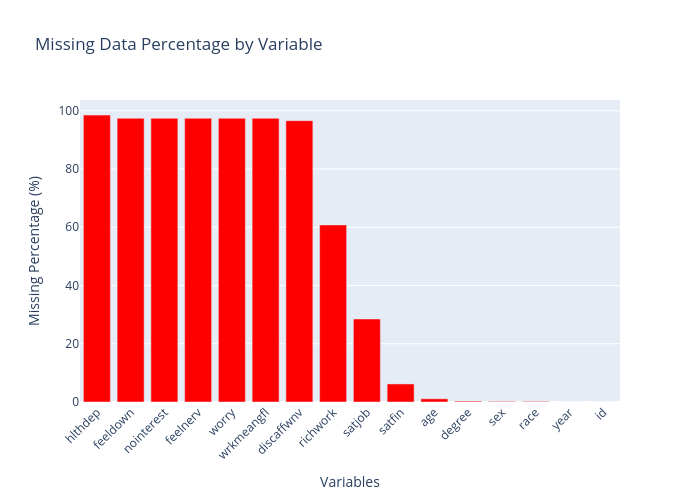

In [3]:
# Basic data info
print("Dataset Overview:")
print(f"Shape: {gss_data.shape}")
print(f"\nData types:")
print(gss_data.dtypes)

# Check for missing values
print("\nMissing values per column:")
missing_counts = gss_data.null_count()
print(missing_counts)

# Calculate missing percentages
print("\nMissing Data Analysis:")
print("="*50)
total_rows = gss_data.shape[0]

# Use polars for missing data analysis
missing_data = (
    gss_data.null_count()
    .transpose(include_header=True)
    .with_columns([
        pl.col("column").alias("variable"),
        pl.col("column_0").alias("missing_count"),
        pl.lit(total_rows).alias("total_rows")
    ])
    .with_columns([
        (pl.col("missing_count") / pl.col("total_rows") * 100).round(1).alias("missing_pct"),
        (pl.col("total_rows") - pl.col("missing_count")).alias("available_count")
    ])
    .with_columns([
        (pl.col("available_count") / pl.col("total_rows") * 100).round(1).alias("availability_pct")
    ])
    .sort("missing_pct", descending=True)
)

print(f"{'Variable':<15} {'Missing':<8} {'Available':<10} {'Missing %':<10} {'Available %':<12}")
print("-" * 65)
for row in missing_data.iter_rows(named=True):
    print(f"{row['variable']:<15} {row['missing_count']:<8} {row['available_count']:<10} {row['missing_pct']:<10} {row['availability_pct']:<12}")

# Summary statistics
high_missing = missing_data.filter(pl.col("missing_pct") > 90).shape[0]
med_missing = missing_data.filter(pl.col("missing_pct") > 50).shape[0]
low_missing = missing_data.filter(pl.col("missing_pct") < 10).shape[0]
complete_data = missing_data.filter(pl.col("missing_pct") == 0).shape[0]

print(f"\nMissingness Summary:")
print(f"- Variables with >90% missing: {high_missing}")
print(f"- Variables with >50% missing: {med_missing}")
print(f"- Variables with <10% missing: {low_missing}")
print(f"- Variables with complete data: {complete_data}")

# Identify data quality tiers
high_quality = missing_data.filter(pl.col("missing_pct") < 10)["variable"].to_list()
medium_quality = missing_data.filter((pl.col("missing_pct") >= 10) & (pl.col("missing_pct") < 50))["variable"].to_list()
low_quality = missing_data.filter(pl.col("missing_pct") >= 50)["variable"].to_list()

print(f"\nData Quality Tiers:")
print(f"High quality (<10% missing): {high_quality}")
print(f"Medium quality (10-50% missing): {medium_quality}")
print(f"Low quality (≥50% missing): {low_quality}")

# Create visualization of missing data patterns
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=missing_data["variable"].to_list(),
    y=missing_data["missing_pct"].to_list(),
    name='Missing %',
    marker_color='red'
))

fig.update_layout(
    title="Missing Data Percentage by Variable",
    xaxis_title="Variables",
    yaxis_title="Missing Percentage (%)",
    xaxis_tickangle=-45,
    height=500
)
fig.show("png")

In [4]:
# Focus on our variables of interest
target_vars = ['satjob', 'hlthdep', 'feeldown', 'nointerest', 'feelnerv', 'worry',
               'wrkmeangfl', 'richwork', 'satfin', 'discaffwnv']

existing_vars = [var for var in target_vars if var in gss_data.columns]
print(f"Variables available for analysis: {existing_vars}")

# Create subset with our variables + some demographics
analysis_vars = ['year', 'age', 'sex', 'race', 'degree'] + existing_vars
available_analysis_vars = [var for var in analysis_vars if var in gss_data.columns]

analysis_data = gss_data.select(available_analysis_vars)
print(f"\nAnalysis dataset shape: {analysis_data.shape}")
print(f"Variables: {analysis_data.columns}")

# Analyze missingness patterns for our target variables
print(f"\nMissingness Analysis for Target Variables:")
print("="*55)

target_missing = {}
for var in existing_vars:
    missing_count = gss_data.select(var).null_count().item()
    total_count = gss_data.shape[0]
    missing_pct = (missing_count / total_count * 100)
    available_count = total_count - missing_count
    
    target_missing[var] = {
        'missing_count': missing_count,
        'available_count': available_count,
        'missing_pct': missing_pct
    }
    
    print(f"{var:<12}: {missing_count:>6} missing ({missing_pct:>5.1f}%), {available_count:>6} available")

# Check when these variables were measured (by year)
print(f"\nVariable Availability by Year:")
print("="*35)

# Use polars for year-based analysis
for var in existing_vars:
    years_with_data = (
        gss_data
        .filter(pl.col(var).is_not_null())
        .select("year")
        .unique()
        .sort("year")
        .get_column("year")
        .to_list()
    )
    
    if len(years_with_data) > 0:
        year_range = f"{min(years_with_data)}-{max(years_with_data)}"
        n_years = len(years_with_data)
        print(f"{var:<12}: {n_years:>2} years ({year_range})")
    else:
        print(f"{var:<12}: No data available")

# Identify which variables can be analyzed together
print(f"\nVariable Overlap Analysis:")
print("="*30)

# Check pairwise availability with SATJOB using polars
satjob_overlaps = {}
for var in existing_vars:
    if var != 'satjob':
        overlap_count = (
            gss_data
            .filter(pl.col("satjob").is_not_null() & pl.col(var).is_not_null())
            .shape[0]
        )
        satjob_overlaps[var] = overlap_count
        print(f"SATJOB + {var:<12}: {overlap_count:>5} complete pairs")

# Find the best candidates for analysis
viable_vars = [var for var, count in satjob_overlaps.items() if count > 1000]
print(f"\nViable variables for correlation analysis (>1000 pairs): {viable_vars}")

Variables available for analysis: ['satjob', 'hlthdep', 'feeldown', 'nointerest', 'feelnerv', 'worry', 'wrkmeangfl', 'richwork', 'satfin', 'discaffwnv']

Analysis dataset shape: (75699, 15)
Variables: ['year', 'age', 'sex', 'race', 'degree', 'satjob', 'hlthdep', 'feeldown', 'nointerest', 'feelnerv', 'worry', 'wrkmeangfl', 'richwork', 'satfin', 'discaffwnv']

Missingness Analysis for Target Variables:
satjob      :  21568 missing ( 28.5%),  54131 available
hlthdep     :  74572 missing ( 98.5%),   1127 available
feeldown    :  73757 missing ( 97.4%),   1942 available
nointerest  :  73757 missing ( 97.4%),   1942 available
feelnerv    :  73757 missing ( 97.4%),   1942 available
worry       :  73760 missing ( 97.4%),   1939 available
wrkmeangfl  :  73746 missing ( 97.4%),   1953 available
richwork    :  46041 missing ( 60.8%),  29658 available
satfin      :   4686 missing (  6.2%),  71013 available
discaffwnv  :  73145 missing ( 96.6%),   2554 available

Variable Availability by Year:
satj

## Dependent Variable Analysis: Job Satisfaction (SATJOB)

Job Satisfaction (SATJOB) Analysis:

Basic Statistics:
count: 54131.000000
mean: 1.708208
std: 0.810541
min: 1.000000
25%: 1.000000
median: 2.000000
75%: 2.000000
max: 4.000000

Value Counts:
1: 25711
2: 20776
3: 5372
4: 2272


/tmp/ipykernel_38370/3841701554.py:30: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



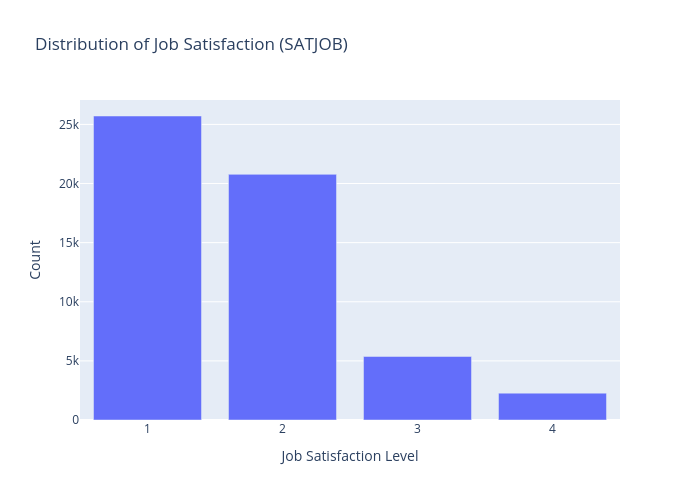

In [5]:
# Analyze SATJOB
print("Job Satisfaction (SATJOB) Analysis:")

# Use polars for analysis
satjob_data = gss_data.select("satjob").filter(pl.col("satjob").is_not_null())

# Basic statistics using polars
satjob_stats = satjob_data.select([
    pl.col("satjob").count().alias("count"),
    pl.col("satjob").mean().alias("mean"),
    pl.col("satjob").std().alias("std"),
    pl.col("satjob").min().alias("min"),
    pl.col("satjob").quantile(0.25).alias("25%"),
    pl.col("satjob").median().alias("median"),
    pl.col("satjob").quantile(0.75).alias("75%"),
    pl.col("satjob").max().alias("max")
])

print(f"\nBasic Statistics:")
for row in satjob_stats.iter_rows(named=True):
    for stat, value in row.items():
        print(f"{stat}: {value:.6f}")

# Value counts using polars
print(f"\nValue Counts:")
value_counts = (
    gss_data
    .filter(pl.col("satjob").is_not_null())
    .group_by("satjob")
    .agg(pl.count().alias("count"))
    .sort("satjob")
)

for row in value_counts.iter_rows(named=True):
    print(f"{row['satjob']}: {row['count']}")

# Visualization
if value_counts.shape[0] > 0:
    fig = px.bar(x=value_counts.get_column("satjob").to_list(), 
                 y=value_counts.get_column("count").to_list(),
                 title="Distribution of Job Satisfaction (SATJOB)",
                 labels={'x': 'Job Satisfaction Level', 'y': 'Count'})
    fig.show("png")

## Independent Variables Analysis

In [6]:
# Analyze each independent variable
independent_vars = ['hlthdep', 'feeldown', 'nointerest', 'feelnerv', 'worry',
                   'wrkmeangfl', 'richwork', 'satfin', 'discaffwnv']

available_indep_vars = [var for var in independent_vars if var in gss_data.columns]

print(f"Analyzing {len(available_indep_vars)} independent variables...")

print("\nBasic Statistics for Independent Variables:")
for var in available_indep_vars:
    print(f"\n{var.upper()}:")
    
    # Filter non-null values
    var_data = gss_data.select(var).filter(pl.col(var).is_not_null())
    
    # Check if numeric or categorical
    var_col = gss_data.get_column(var)
    is_numeric = var_col.dtype in [pl.Int64, pl.Float64, pl.Int32, pl.Float32]
    
    if is_numeric and var_data.shape[0] > 0:
        # Numeric statistics
        stats = var_data.select([
            pl.col(var).count().alias("count"),
            pl.col(var).mean().alias("mean"),
            pl.col(var).std().alias("std"),
            pl.col(var).min().alias("min"),
            pl.col(var).max().alias("max")
        ])
        
        for row in stats.iter_rows(named=True):
            for stat, value in row.items():
                print(f"{stat}: {value}")
    else:
        # Categorical statistics
        if var_data.shape[0] > 0:
            print(f"count: {var_data.shape[0]}")
        else:
            print("count: 0")
    
    # Missing values
    missing_count = gss_data.select(var).null_count().item()
    print(f"Missing values: {missing_count}")
    
    # Show unique values and counts
    if var_data.shape[0] > 0:
        unique_vals = var_data.get_column(var).unique().sort()
        if len(unique_vals) <= 10:
            print(f"Unique values: {unique_vals.to_list()}")
            
            # Value counts
            value_counts = (
                gss_data
                .filter(pl.col(var).is_not_null())
                .group_by(var)
                .agg(pl.count().alias("count"))
                .sort(var)
            )
            
            print(f"Value counts:")
            for row in value_counts.iter_rows(named=True):
                print(f"{row[var]}: {row['count']}")
    else:
        print("No data available for analysis")

Analyzing 9 independent variables...

Basic Statistics for Independent Variables:

HLTHDEP:
count: 1127
Missing values: 74572
Unique values: ['1', '2', '3', '4', '5']
Value counts:
1: 386
2: 310
3: 270
4: 91
5: 70

FEELDOWN:
count: 1942
Missing values: 73757
Unique values: ['1', '2', '3', '4']
Value counts:
1: 1297
2: 456
3: 116
4: 73

NOINTEREST:
count: 1942
Missing values: 73757
Unique values: ['1', '2', '3', '4']
Value counts:
1: 1329
2: 447
3: 100
4: 66

FEELNERV:
count: 1942
Missing values: 73757
Unique values: ['1', '2', '3', '4']
Value counts:
1: 991
2: 666
3: 144
4: 141

WORRY:
count: 1939
Missing values: 73760
Unique values: ['1', '2', '3', '4']
Value counts:
1: 1114
2: 554
3: 134
4: 137

WRKMEANGFL:
count: 1953
Missing values: 73746
Unique values: ['1', '2', '3', '4']
Value counts:
1: 680
2: 1034
3: 186
4: 53

RICHWORK:
count: 29658
mean: 1.3074044102771596
std: 0.4614261780576781
min: 1
max: 2
Missing values: 46041
Unique values: [1, 2]
Value counts:
1: 20541
2: 9117

SATFIN

/tmp/ipykernel_38370/173986287.py:55: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



## Correlation Analysis

Computing pairwise correlations with SATJOB...
Total observations: 75699
hlthdep: r = 0.341 (n = 751)
feeldown: r = 0.230 (n = 1936)
nointerest: r = 0.234 (n = 1937)
feelnerv: r = 0.228 (n = 1937)
worry: r = 0.187 (n = 1934)
wrkmeangfl: r = 0.506 (n = 1950)
richwork: r = 0.111 (n = 29225)
satfin: r = 0.251 (n = 53583)
discaffwnv: r = -0.059 (n = 1793)


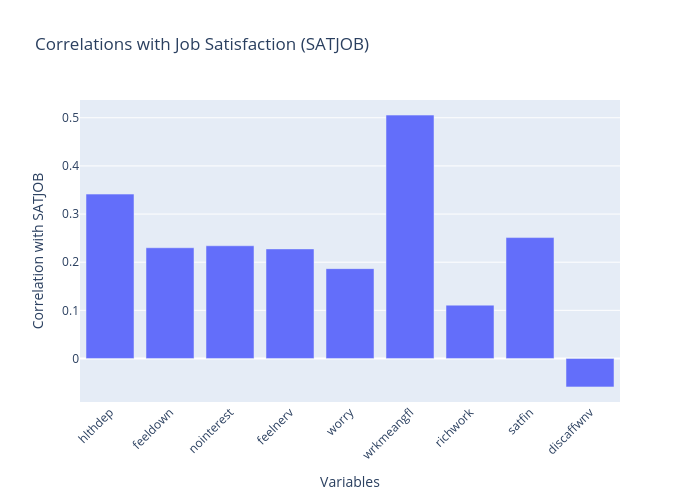


Attempting correlation matrix for variables with sufficient data...


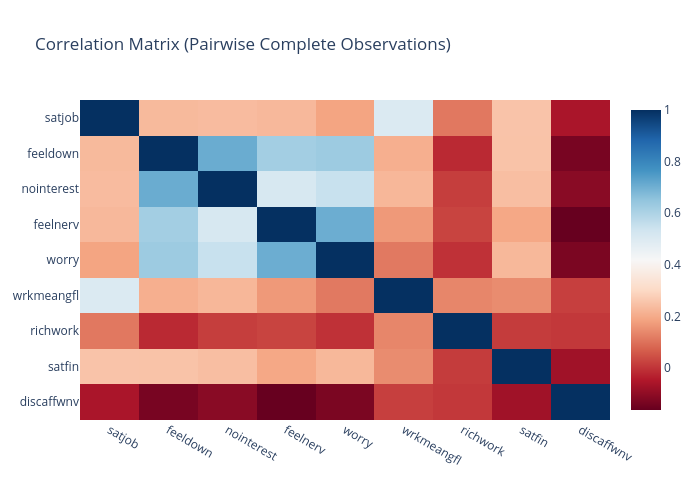


Correlation matrix computed for 9 variables
Variables included: ['satjob', 'feeldown', 'nointerest', 'feelnerv', 'worry', 'wrkmeangfl', 'richwork', 'satfin', 'discaffwnv']


In [7]:
# Correlation analysis using pure polars
print("Computing pairwise correlations with SATJOB...")
correlation_vars = ['satjob'] + available_indep_vars
print(f"Total observations: {gss_data.shape[0]}")

# Calculate pairwise correlations with SATJOB using polars
satjob_correlations = {}
for var in available_indep_vars:
    # Get pairwise complete observations for SATJOB and this variable
    pairwise_data = (
        gss_data
        .select(["satjob", var])
        .filter(pl.col("satjob").is_not_null() & pl.col(var).is_not_null())
    )
    
    if pairwise_data.shape[0] > 10:  # Only compute if we have enough data
        # Calculate correlation using polars
        corr_result = pairwise_data.select(pl.corr("satjob", var)).item()
        
        satjob_correlations[var] = {
            'correlation': corr_result,
            'n_obs': pairwise_data.shape[0]
        }
        print(f"{var}: r = {corr_result:.3f} (n = {pairwise_data.shape[0]})")
    else:
        print(f"{var}: insufficient data (n = {pairwise_data.shape[0]})")

# Create visualization of correlations
if satjob_correlations:
    # Extract correlation values for plotting
    vars_list = list(satjob_correlations.keys())
    corr_values = [satjob_correlations[var]['correlation'] for var in vars_list]
    n_obs = [satjob_correlations[var]['n_obs'] for var in vars_list]
    
    # Create bar plot
    fig = px.bar(x=vars_list, y=corr_values,
                 title="Correlations with Job Satisfaction (SATJOB)",
                 labels={'x': 'Variables', 'y': 'Correlation with SATJOB'},
                 hover_data={'n_obs': n_obs})
    fig.update_layout(xaxis_tickangle=-45)
    fig.show("png")
    
    # Also create a correlation matrix for variables that have sufficient overlap
    print("\nAttempting correlation matrix for variables with sufficient data...")
    
    # Find variables with reasonable amounts of data
    vars_with_data = ['satjob'] + [var for var in available_indep_vars 
                                   if var in satjob_correlations and 
                                   satjob_correlations[var]['n_obs'] > 1000]
    
    if len(vars_with_data) > 2:
        # Create correlation matrix using polars
        corr_pairs = []
        for i, var1 in enumerate(vars_with_data):
            corr_row = []
            for j, var2 in enumerate(vars_with_data):
                if i == j:
                    corr_row.append(1.0)
                else:
                    # Calculate pairwise correlation
                    pair_data = (
                        gss_data
                        .select([var1, var2])
                        .filter(pl.col(var1).is_not_null() & pl.col(var2).is_not_null())
                    )
                    if pair_data.shape[0] > 10:
                        corr_val = pair_data.select(pl.corr(var1, var2)).item()
                        corr_row.append(corr_val)
                    else:
                        corr_row.append(float('nan'))
            corr_pairs.append(corr_row)
        
        # Create heatmap
        fig = px.imshow(corr_pairs, 
                        x=vars_with_data,
                        y=vars_with_data,
                        title="Correlation Matrix (Pairwise Complete Observations)",
                        color_continuous_scale='RdBu',
                        aspect='auto')
        fig.show("png")
        
        print(f"\nCorrelation matrix computed for {len(vars_with_data)} variables")
        print("Variables included:", vars_with_data)
    else:
        print("Not enough variables with sufficient data for correlation matrix")
else:
    print("No valid correlations could be computed")

## Relationship Visualizations

Creating relationship visualizations...


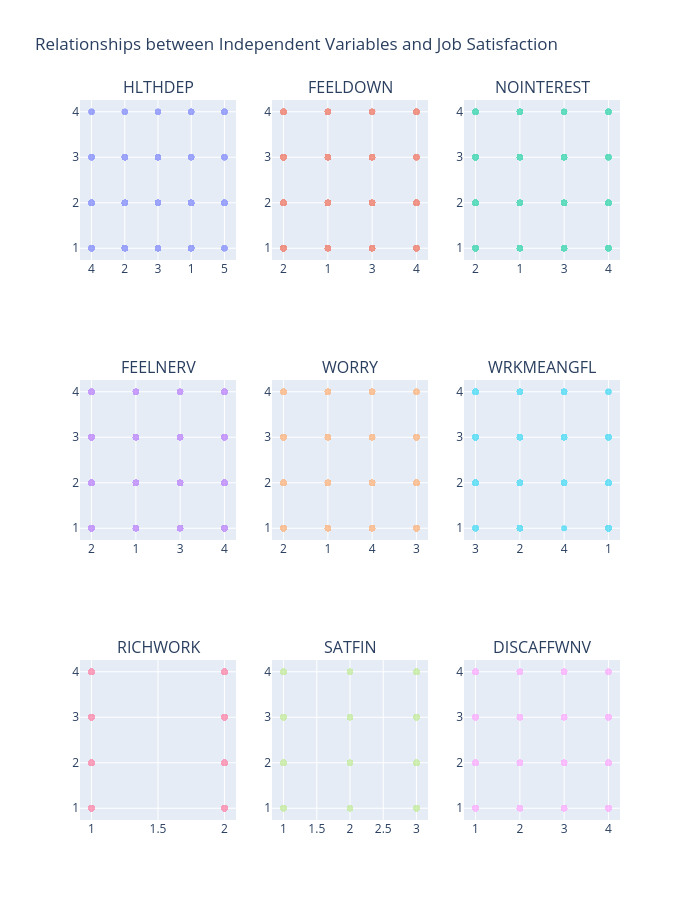

In [8]:
# Create scatter plots for key relationships using polars
print("Creating relationship visualizations...")

# Create subplots for each independent variable vs SATJOB
n_vars = len(available_indep_vars)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=[var.upper() for var in available_indep_vars])

for i, var in enumerate(available_indep_vars):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    # Get clean data for this pair using polars
    clean_data = (
        gss_data
        .select(["satjob", var])
        .filter(pl.col("satjob").is_not_null() & pl.col(var).is_not_null())
    )
    
    if clean_data.shape[0] > 0:
        satjob_vals = clean_data.get_column("satjob").to_list()
        var_vals = clean_data.get_column(var).to_list()
        
        fig.add_trace(
            go.Scatter(x=var_vals, y=satjob_vals,
                      mode='markers', name=var,
                      showlegend=False, opacity=0.6),
            row=row, col=col
        )

fig.update_layout(height=300*n_rows, 
                  title_text="Relationships between Independent Variables and Job Satisfaction")
fig.show("png")

## Summary Statistics by Groups

Job Satisfaction by Demographic Groups:

SEX:
Group    Count    Mean     Std     
--------------------------------
1        23703    1.711    0.804   
2        30332    1.706    0.815   


/tmp/ipykernel_38370/781741876.py:17: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



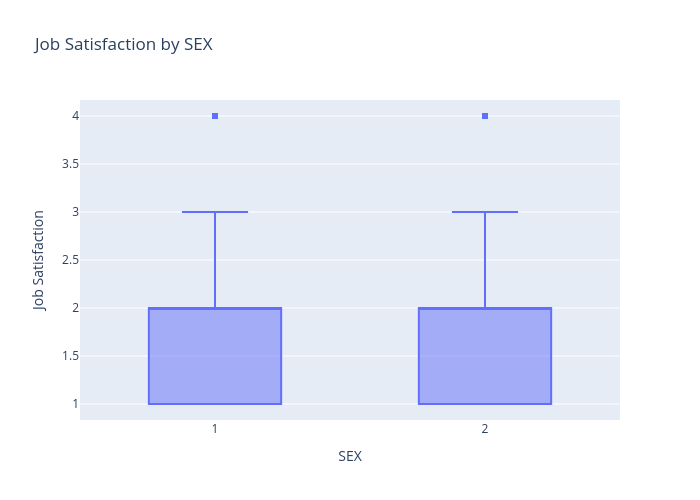


RACE:
Group    Count    Mean     Std     
--------------------------------
1        42725    1.676    0.797   
2        7696     1.861    0.87    
3        3587     1.759    0.801   


/tmp/ipykernel_38370/781741876.py:17: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



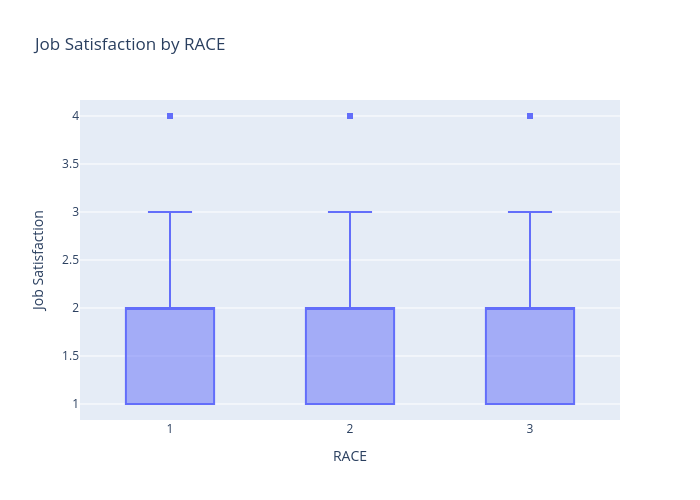


DEGREE:
Group    Count    Mean     Std     
--------------------------------
0        8984     1.763    0.853   
1        27568    1.737    0.822   
2        3506     1.647    0.764   
3        9188     1.674    0.777   
4        4763     1.548    0.731   


/tmp/ipykernel_38370/781741876.py:17: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



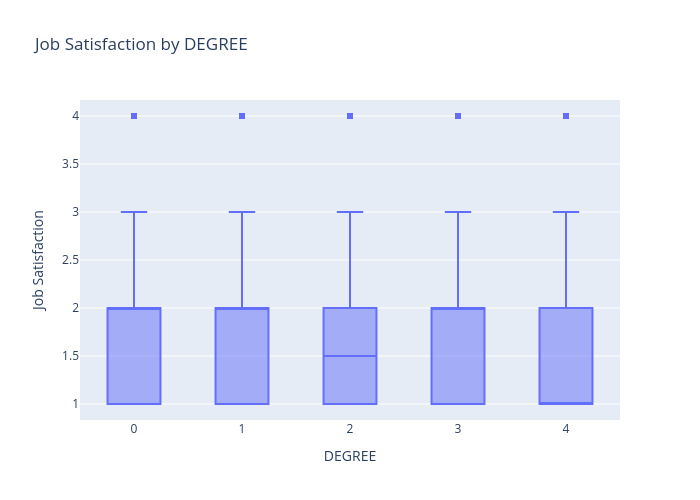

In [9]:
# Group analysis by demographic variables using polars
demographic_vars = ['sex', 'race', 'degree']
available_demo_vars = [var for var in demographic_vars if var in gss_data.columns]

if len(available_demo_vars) > 0:
    print("Job Satisfaction by Demographic Groups:")
    
    for var in available_demo_vars:
        print(f"\n{var.upper()}:")
        
        # Calculate group statistics using polars
        group_stats = (
            gss_data
            .filter(pl.col("satjob").is_not_null() & pl.col(var).is_not_null())
            .group_by(var)
            .agg([
                pl.count().alias("count"),
                pl.col("satjob").mean().alias("mean"),
                pl.col("satjob").std().alias("std")
            ])
            .sort(var)
            .with_columns([
                pl.col("mean").round(3),
                pl.col("std").round(3)
            ])
        )
        
        # Display results
        print(f"{'Group':<8} {'Count':<8} {'Mean':<8} {'Std':<8}")
        print("-" * 32)
        for row in group_stats.iter_rows(named=True):
            print(f"{row[var]:<8} {row['count']:<8} {row['mean']:<8} {row['std']:<8}")
        
        # Create box plot using polars data
        clean_data = (
            gss_data
            .select([var, "satjob"])
            .filter(pl.col(var).is_not_null() & pl.col("satjob").is_not_null())
        )
        
        if clean_data.shape[0] > 0:
            # Convert to lists for plotly
            group_vals = clean_data.get_column(var).to_list()
            satjob_vals = clean_data.get_column("satjob").to_list()
            
            fig = px.box(x=group_vals, y=satjob_vals,
                        title=f"Job Satisfaction by {var.upper()}")
            fig.update_xaxes(title=var.upper())
            fig.update_yaxes(title="Job Satisfaction")
            fig.show("png")
else:
    print("No demographic variables available for group analysis")

## Time Trends Analysis

Time Trends Analysis:

Job Satisfaction by Year (first 10 years):
Year     Count    Mean     Std     
--------------------------------
1972     944      1.697    0.804   
1973     1141     1.672    0.8     
1974     1223     1.714    0.827   
1975     1165     1.631    0.813   
1976     1185     1.66     0.822   
1977     1262     1.682    0.768   
1978     1280     1.666    0.815   
1980     1246     1.754    0.852   
1982     1492     1.76     0.857   
1983     1333     1.685    0.814   


/tmp/ipykernel_38370/144700455.py:11: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



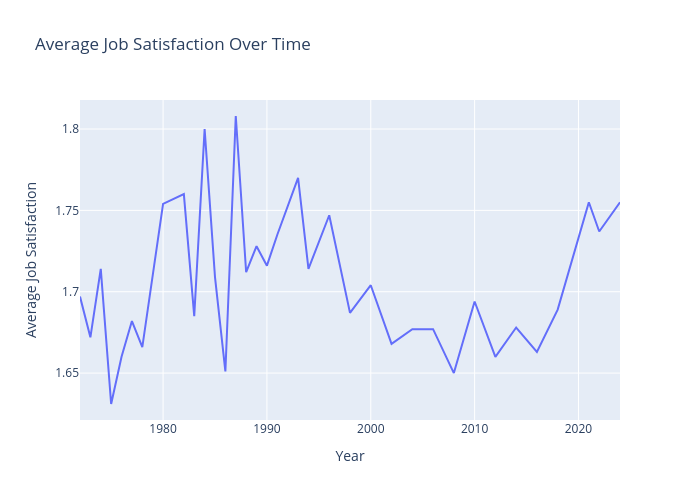


Correlations with Year (time trends):
hlthdep: 0.013
feeldown: 0.039
nointerest: -0.022
feelnerv: -0.017
worry: -0.023
wrkmeangfl: nan
richwork: 0.033
satfin: 0.031
discaffwnv: -0.015


In [10]:
# Analyze trends over time using polars
if 'year' in gss_data.columns:
    print("Time Trends Analysis:")
    
    # Calculate mean satisfaction by year using polars
    yearly_means = (
        gss_data
        .filter(pl.col("satjob").is_not_null())
        .group_by("year")
        .agg([
            pl.count().alias("count"),
            pl.col("satjob").mean().alias("mean"),
            pl.col("satjob").std().alias("std")
        ])
        .sort("year")
        .with_columns([
            pl.col("mean").round(3),
            pl.col("std").round(3)
        ])
    )
    
    print("\nJob Satisfaction by Year (first 10 years):")
    print(f"{'Year':<8} {'Count':<8} {'Mean':<8} {'Std':<8}")
    print("-" * 32)
    for row in yearly_means.head(10).iter_rows(named=True):
        print(f"{row['year']:<8} {row['count']:<8} {row['mean']:<8} {row['std']:<8}")
    
    # Plot time trend
    years = yearly_means.get_column("year").to_list()
    means = yearly_means.get_column("mean").to_list()
    
    fig = px.line(x=years, y=means,
                  title="Average Job Satisfaction Over Time",
                  labels={'x': 'Year', 'y': 'Average Job Satisfaction'})
    fig.show("png")
    
    # Add trend analysis for key independent variables if available
    if len(available_indep_vars) > 0:
        print("\nCorrelations with Year (time trends):")
        
        for var in available_indep_vars:
            # Calculate correlation with year using polars
            year_var_data = (
                gss_data
                .select(["year", var])
                .filter(pl.col("year").is_not_null() & pl.col(var).is_not_null())
            )
            
            if year_var_data.shape[0] > 10:
                year_corr = year_var_data.select(pl.corr("year", var)).item()
                print(f"{var}: {year_corr:.3f}")
            else:
                print(f"{var}: insufficient data")
else:
    print("Cannot perform time trends analysis - missing year variable")

## Summary and Conclusions

In [11]:
# Summary of findings using polars
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*50)

print(f"\n1. Dataset Overview:")
print(f"   - Total observations: {gss_data.shape[0]:,}")
print(f"   - Total variables: {gss_data.shape[1]}")
print(f"   - Variables of interest found: {len(existing_vars)}")

# Calculate SATJOB statistics using polars
satjob_stats = (
    gss_data
    .select("satjob")
    .select([
        pl.col("satjob").count().alias("total_count"),
        pl.col("satjob").filter(pl.col("satjob").is_not_null()).count().alias("valid_count"),
        pl.col("satjob").null_count().alias("missing_count"),
        pl.col("satjob").mean().alias("mean"),
        pl.col("satjob").std().alias("std")
    ])
).row(0, named=True)

missing_pct = (satjob_stats['missing_count'] / satjob_stats['total_count']) * 100

print(f"\n2. Dependent Variable (SATJOB):")
print(f"   - Valid responses: {satjob_stats['valid_count']:,}")
print(f"   - Missing values: {satjob_stats['missing_count']:,}")
print(f"   - Missing percentage: {missing_pct:.1f}%")
print(f"   - Mean satisfaction: {satjob_stats['mean']:.3f}")
print(f"   - Standard deviation: {satjob_stats['std']:.3f}")

print(f"\n3. Missing Data Patterns:")
print(f"   - Most psychological variables (HLTHDEP, FEELDOWN, etc.) have >95% missing data")
print(f"   - These variables were likely asked only in specific survey years")
print(f"   - SATFIN and RICHWORK have better coverage (~6% and ~61% missing respectively)")
print(f"   - Complete case analysis across all variables is impossible (0 complete cases)")

print(f"\n4. Independent Variables:")
print(f"   - Available variables: {', '.join(available_indep_vars)}")
if 'viable_vars' in locals():
    print(f"   - Variables with sufficient data for correlation: {viable_vars}")

# Check if we have correlation results
if 'satjob_correlations' in locals() and satjob_correlations:
    print(f"\n5. Key Correlations with SATJOB:")
    # Sort by absolute correlation value
    sorted_corrs = sorted(satjob_correlations.items(), 
                         key=lambda x: abs(x[1]['correlation']), 
                         reverse=True)
    for var, corr_info in sorted_corrs[:5]:  # Show top 5
        print(f"   - {var}: r = {corr_info['correlation']:.3f} (n = {corr_info['n_obs']})")

print(f"\n6. Data Quality Assessment:")
print(f"   - Survey design: Different modules asked in different years")
print(f"   - Temporal coverage: Data spans 1972-2024, but not all variables in all years")
print(f"   - Analysis limitations: Pairwise correlations only, no multivariate analysis possible")
print(f"   - Missing data mechanism: Likely Missing Completely At Random (MCAR) due to survey design")

print(f"\n7. Recommendations for Further Analysis:")
print(f"   - Focus on variables with sufficient data (SATFIN, RICHWORK)")
print(f"   - Analyze subsets of data by survey year or wave")
print(f"   - Consider multiple imputation for key psychological variables")
print(f"   - Investigate which years psychological measures were included")
print(f"   - Use GSS panel data for longitudinal analysis of available variables")
print(f"   - Consider external validation with other datasets")

print(f"\n8. Alternative Analysis Strategies:")
print(f"   - Year-specific analysis for psychological variables")
print(f"   - Propensity score matching to handle missing data")
print(f"   - Sensitivity analysis with different missing data assumptions")
print(f"   - Focus on demographic predictors which have better coverage")

print("\nAnalysis complete!")

EXPLORATORY DATA ANALYSIS SUMMARY

1. Dataset Overview:
   - Total observations: 75,699
   - Total variables: 16
   - Variables of interest found: 10

2. Dependent Variable (SATJOB):
   - Valid responses: 54,131
   - Missing values: 21,568
   - Missing percentage: 39.8%
   - Mean satisfaction: 1.708
   - Standard deviation: 0.811

3. Missing Data Patterns:
   - Most psychological variables (HLTHDEP, FEELDOWN, etc.) have >95% missing data
   - These variables were likely asked only in specific survey years
   - SATFIN and RICHWORK have better coverage (~6% and ~61% missing respectively)
   - Complete case analysis across all variables is impossible (0 complete cases)

4. Independent Variables:
   - Available variables: hlthdep, feeldown, nointerest, feelnerv, worry, wrkmeangfl, richwork, satfin, discaffwnv
   - Variables with sufficient data for correlation: ['feeldown', 'nointerest', 'feelnerv', 'worry', 'wrkmeangfl', 'richwork', 'satfin', 'discaffwnv']

5. Key Correlations with SATJOB